# Teachers Prediction:

## 1. Predict bad teacher:
This part of the jupyter's notebook computes different models to predict if a teacher performed bad (least 30 percentile) in the portfolio test based on information we have about their performance in PAA/PSU and GPA.

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.plotly as py
from scipy import stats
from sklearn import datasets, linear_model, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree, svm
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression

First, let's open the information available to run the models:

In [2]:
df_path = os.getcwd() + '\data\PAA-evdoc.csv'
df = None
#with open(df_path, encoding="utf-16") as f:
with open(df_path, "r") as f:
    df = pd.read_csv(f)

df.head(2)

,periodo,ciclo,subsector,pf_pje,instr_pje,esc_r,Te_EvLevel,proceso,pref,cod,...,DeltaAvePrivado2,Duration,Duration2,DeltaDuration,DeltaDuration2,Type1,Type2,Type3,Type4,_merge
0,2006,2do Ciclo,Matemática,2.27,2.66,Competente,2,1977,1.0,3537,...,-0.014692,6.0,36.0,1.0,11.0,0,1,0,0,3
1,2006,2do Ciclo,Matemática,2.27,2.66,Competente,2,1978,3.0,3303,...,NaN,5.0,25.0,NaN,NaN,0,1,0,0,3


Quick df clean:

In [3]:
#Quick df clean:
scores = ['paa_verbal', 'paa_matematica', 'nem', 'gpa', 'pce_hria_y_geografia', 'pce_biologia', 'pce_cs_sociales', 'pce_fisica', 'pce_matematica', 'pce_quimica']
cat = ['region', 'male']
df_s = df[scores].copy()

bygroup = 0
if bygroup == 1:
    df_s['periodo'] = df['periodo']
    df_s = df_s.groupby('periodo').transform(lambda x: (x - x.mean()) / x.std())
else:
    df_s = (df[scores] - df[scores].mean())/df[scores].std()
df_s['Average'] = (df['paa_verbal'] + df['paa_matematica'])/2

df_c = df[cat].copy()

df_s['took_hist'] = (df.pce_hria_y_geografia == 0)
df_s['took_bio'] = (df.pce_biologia == 0)
df_s['took_soc'] = (df.pce_cs_sociales == 0)
df_s['took_fis'] = (df.pce_fisica == 0)
df_s['took_mat'] = (df.pce_matematica == 0)
df_s['took_qui'] = (df.pce_quimica == 0)

y = df['pf_pje']

df = pd.concat([df_s, df_c, y], axis=1, sort=False)

df = df.dropna()
df.region = df.region.astype(int)
df.male = df.male.astype(int)

#Divide the sample distribution in 10 types:
df['xtile'] = pd.qcut(df.pf_pje, 10, labels = ['percentil: '+str(i) for i in range(10)])
df['worst'] = (df['xtile'] == 'percentil: 0' ) | (df['xtile'] == 'percentil: 1') | (df['xtile'] == 'percentil: 2')

df.columns = ['paaverbal' if x=='paa_verbal' else 'paamat' if x =='paa_matematica' else x for x in df.columns] #Change colname

x_variables = [x if (x!='pf_pje' and x!='xtile' and x!='worst' and x!='region9') else "AAA" for x in list(df)]
x_variables = sorted(list(set(x_variables)))
del x_variables[0]

X_transformed = df[x_variables].dropna().drop(columns = ['region',
'pce_biologia', 'pce_cs_sociales', 'pce_fisica', 'pce_hria_y_geografia', 'pce_matematica', 'pce_quimica'])
#'took_bio', 'took_fis', 'took_hist', 'took_mat', 'took_qui', 'took_soc', 'paamat', 'paaverbal'

X_transformed['paa_avg'] = (X_transformed.Average - X_transformed.Average.mean())/X_transformed.Average.std()
Y = df['worst']

X_transformed = X_transformed.drop(columns = ['Average', 'paa_avg', 'gpa'])

X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, Y, test_size=0.15)


### 1.1. Likelihood vs teacher performance scatterplot

Define a function which inserts the predictions (predict) and the likelihood (predict_proba) in the main dataframe. One can easily change the model introducing the name of the predictive model in the args.

In [4]:
def gen_predictions(Classifier, X_train, X_test, y_train):
    from sklearn import tree, svm
    SVC = svm.SVC
    if Classifier == SVC:
        clf = Classifier(C=1, probability=True)
    else:
        clf = Classifier()
    clf = clf.fit(X_train, y_train)

    y_test_hat = clf.predict_proba(X_test)[:,1]  #Prob of bad Teacher
    y_test_predict = clf.predict(X_test)  #Prob of bad Teacher

    ndf = y_test_hat.shape[0]
    df_ml_test = X_test.copy()
    df_ml_test['y_test_hat'] = y_test_hat
    df_ml_test = df_ml_test.sort_values(by = ['y_test_hat'])

    return df_ml_test, clf.predict_proba(X_test), y_test_predict

In [5]:
df_rf_test , y_test_hat, y_test_predict = gen_predictions(RandomForestClassifier, X_train_transformed, X_test_transformed, y_train)

In [6]:
accuracy = np.mean(y_test_predict == y_test)
type1_error = 1 - np.mean(y_test[y_test==1] == y_test_predict[y_test==1]) #Type 1 error: Probabilidad de predecir que no es malo cuando si lo es
type2_error = 1 - np.mean(y_test[y_test_predict == 1] == y_test_predict[y_test_predict == 1]) #probabilidad de predecir que profesor es malo cuando en realidad es bueno (Error tipo 2)

print("Overall Accuracy: %.2f \nType 1 error: %.2f \nType 2 error:  %.2f" % (accuracy, type1_error, type2_error))


Overall Accuracy: 0.90 
Type 1 error: 0.25 
Type 2 error:  0.09


Plot Results of the Model. In this case we are using Random forest Estimation

#### Graph 1: Likelihood vs PAA Math

Text(0.5,0,'PAA Math')

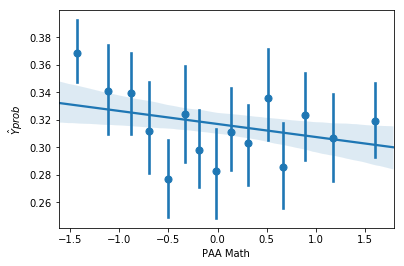

In [7]:
sns.regplot(df_rf_test.paamat, df_rf_test.y_test_hat, x_bins = 15)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('PAA Math')
#plt.savefig(r'C:\\Users\\Franco\\GitHub\\teacher-predictions\\output\\Pr_vs_paa_mat.pdf', bbox_inches='tight')

#### Graph 2: Likelihood vs PAA Verbal

Text(0.5,0,'PAA Verbal')

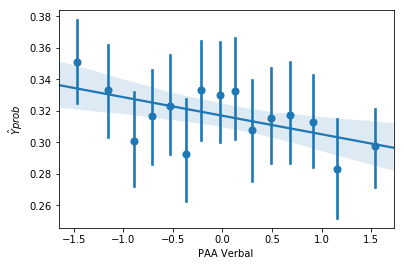

In [8]:
sns.regplot(df_rf_test.paaverbal, df_rf_test.y_test_hat, x_bins = 15)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('PAA Verbal')
#plt.savefig(r'C:\\Users\\Franco\\GitHub\\teacher-predictions\\output\\Pr_vs_paa_verbal.pdf', bbox_inches='tight')

#### Graph 3: Likelihood vs PAA Average

Text(0.5,0,'PAA Average')

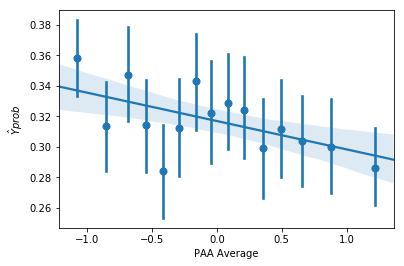

In [9]:
df_rf_test['paa_avg'] = (df_rf_test.paaverbal + df_rf_test.paamat)/2
sns.regplot(df_rf_test.paa_avg, df_rf_test.y_test_hat, x_bins = 15)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('PAA Average')
#plt.savefig(r'C:\\Users\\Franco\\GitHub\\teacher-predictions\\output\\Pr_vs_paa_avg.pdf', bbox_inches='tight')

#### Graph 4: Likelihood vs GPA

Text(0.5,0,'GPA')

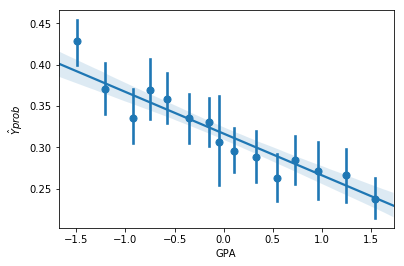

In [11]:
sns.regplot(df_rf_test.nem, df_rf_test.y_test_hat, x_bins = 15)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('GPA')
#plt.savefig(r'C:\\Users\\Franco\\GitHub\\teacher-predictions\\output\\Pr_vs_gpa.pdf', bbox_inches='tight')

### 1.2. Sensitivity Analysis

#### Graph 5: Accuracy of the model by each level likelihood

Text(0,0.5,'Accuracy: 1 - Pr(failure)')

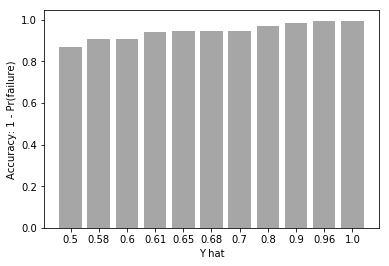

In [12]:
accuracy_list = []
pr_list = list(np.unique(y_test_hat[:,1][y_test_hat[:,1]>=.5]))
for pr in pr_list:
    acc = np.mean(y_test[y_test_hat[:,1]>=pr] == y_test_predict[y_test_hat[:,1]>=pr])
    accuracy_list.append(acc)

ticks = np.arange(len(accuracy_list))
pr_list = [round(x, 2) for x in pr_list]
ticks_label = [str(x) for x in pr_list]

plt.bar(ticks,accuracy_list, align='center', alpha=0.7, color = 'gray')
plt.xticks(ticks, ticks_label)
plt.xlabel('Y hat')
plt.ylabel('Accuracy: 1 - Pr(failure)')
#plt.savefig(r'D:\\Google Drive\\Teacher Quality\\4. Work\\Prediction\\Appendix\\accuracy.pdf', bbox_inches='tight')

### 1.3. Cross Validation

In [14]:
from sklearn import tree, svm
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#CrossValidation Excercise Accuracy tests:
accuracy_type2_rf = []
accuracy_overall_rf = []

accuracy_type2_dt = []
accuracy_overall_dt = []

accuracy_type2_svc = []
accuracy_overall_svc = []

accuracy_type2_lr = []
accuracy_overall_lr = []

# Cross Validate

for i in range(150):

    X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, Y, test_size=0.15)

    clf = RandomForestClassifier()
    clf = clf.fit(X_train_transformed, y_train)
    y_test_hat = clf.predict(X_test_transformed)  #Prob of bad Teacher
    acc_overall = np.mean(y_test == y_test_hat)
    acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
    accuracy_overall_rf.append(acc_overall)
    accuracy_type2_rf.append(acc_type2)

    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train_transformed, y_train)
    y_test_hat = clf.predict(X_test_transformed)  #Prob of bad Teacher
    acc_overall = np.mean(y_test == y_test_hat)
    acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
    accuracy_overall_dt.append(acc_overall)
    accuracy_type2_dt.append(acc_type2)

    clf = LogisticRegression()
    clf = clf.fit(X_train_transformed, y_train)
    y_test_hat = clf.predict(X_test_transformed)  #Prob of bad Teacher
    acc_overall = np.mean(y_test == y_test_hat)
    acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
    accuracy_overall_lr.append(acc_overall)
    accuracy_type2_lr.append(acc_type2)
    
    if (i+1)%50 == 0:
        print(f"Crosvalidation: {i}")


Crosvalidation: 49
Crosvalidation: 99
Crosvalidation: 149


#### Graph 6: Cross Validation Random Forest

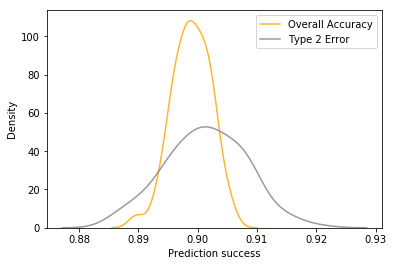

In [15]:
sns.kdeplot(accuracy_overall_rf, alpha=0.8, color = 'orange', label = 'Overall Accuracy')
sns.kdeplot(accuracy_type2_rf, alpha=0.8, color = 'gray', label = 'Type 2 Error')
plt.xlabel('Prediction success')
plt.ylabel('Density')
plt.legend(loc=1)

#### Graph 7: Cross Validation Random Forest vs Decision Tree

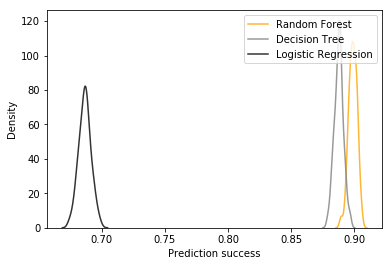

In [16]:
sns.kdeplot(accuracy_overall_rf, alpha=0.8, color = 'orange', label = 'Random Forest')
sns.kdeplot(accuracy_overall_dt, alpha=0.8, color = 'gray', label = 'Decision Tree')
sns.kdeplot(accuracy_overall_lr, alpha=0.8, color = 'black', label = 'Logistic Regression')
plt.xlabel('Prediction success')
plt.ylabel('Density')
plt.legend(loc=1)

#### Graph 8: Cross Validation RF vs DT (type 2 error)

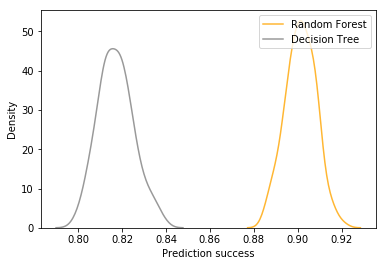

In [17]:
sns.kdeplot(accuracy_type2_rf, alpha=0.8, color = 'orange', label = 'Random Forest')
sns.kdeplot(accuracy_type2_dt, alpha=0.8, color = 'gray', label = 'Decision Tree')
plt.xlabel('Prediction success')
plt.ylabel('Density')
plt.legend(loc=1)

### 1.4. Get importance of the variables of the best model

In [18]:
clf = RandomForestClassifier()
clf = clf.fit(X_train_transformed, y_train)
y_test_hat = clf.predict(X_test_transformed)  #Prob of bad Teacher
acc_overall = np.mean(y_test == y_test_hat)
acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
accuracy_overall_rf.append(acc_overall)
accuracy_type2_rf.append(acc_type2)

importance = clf.feature_importances_
FeatImp = {}

feature_list = list(X_train_transformed.columns)

for x in range(0,len(feature_list)):
    if importance[x]>0:
        FeatImp[feature_list[x]]=importance[x]
        
s = [(k, FeatImp[k]) for k in sorted(FeatImp, key=FeatImp.get, reverse=True)]
for item in s:
    print(item)

('paaverbal', 0.32877396686268384)
('paamat', 0.3196027892337282)
('nem', 0.24064939612066608)
('took_soc', 0.025438906358947272)
('took_bio', 0.019374678197366445)
('took_hist', 0.01831667349400126)
('took_mat', 0.01673370761948829)
('took_fis', 0.012675155574841604)
('took_qui', 0.012112948003752408)
('male', 0.006321778534524575)


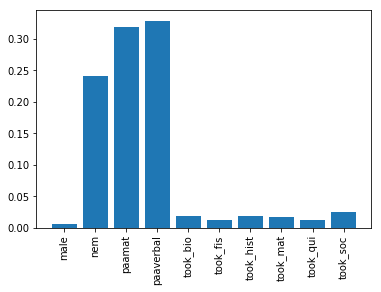

In [23]:
plt.bar(range(len(FeatImp)), list(FeatImp.values()), align='center')
plt.xticks(range(len(FeatImp)), list(FeatImp.keys()), rotation='vertical')
plt.show()

### 1.4. Prediction of the portfolio score

In [ ]:
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, Y, test_size=0.15)

clf = RandomForestClassifier()
clf = clf.fit(X_train_transformed, y_train)
y_test_hat = clf.predict(X_test_transformed)  #Prob of bad Teacher
acc_overall = np.mean(y_test == y_test_hat)
acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
accuracy_overall_rf.append(acc_overall)
accuracy_type2_rf.append(acc_type2)

importance = clf.feature_importances_
FeatImp = {}

feature_list = list(X_train_transformed.columns)

for x in range(0,len(feature_list)):
    if importance[x]>0:
        FeatImp[feature_list[x]]=importance[x]
        
s = [(k, FeatImp[k]) for k in sorted(FeatImp, key=FeatImp.get, reverse=True)]
for item in s:
    print(item)

((56947, 10), (56947, 22))

,paaverbal,paamat,nem,gpa,pce_hria_y_geografia,pce_biologia,pce_cs_sociales,pce_fisica,pce_matematica,pce_quimica,...,took_bio,took_soc,took_fis,took_mat,took_qui,region,male,pf_pje,xtile,worst
1,2.630982,1.524038,-1.034711,-1.037659,-0.923617,0.982383,1.227033,2.419959,1.193927,-0.397064,...,False,False,False,False,True,6,1,2.27,percentil: 4,False
2,2.630982,1.524038,-1.034711,-1.037659,-0.923617,0.982383,1.227033,2.419959,1.193927,-0.397064,...,False,False,False,False,True,6,1,2.27,percentil: 4,False
3,2.446207,1.624895,-1.319489,-1.323083,-0.923617,-1.229576,1.464290,-0.480576,1.154688,-0.397064,...,True,False,True,False,True,7,1,2.27,percentil: 4,False
4,2.630982,1.524038,-1.034711,-1.037659,-0.923617,0.982383,1.227033,2.419959,1.193927,-0.397064,...,False,False,False,False,True,6,1,2.27,percentil: 4,False
7,2.375139,0.679358,-0.806889,-0.809320,-0.923617,1.081883,-1.156490,-0.480576,1.288101,-0.397064,...,False,True,True,False,True,6,0,2.06,percentil: 1,True


,male,nem,paamat,paaverbal,took_bio,took_fis,took_hist,took_mat,took_qui,took_soc
1,1,-1.034711,1.524038,2.630982,False,False,True,False,True,False
2,1,-1.034711,1.524038,2.630982,False,False,True,False,True,False
3,1,-1.319489,1.624895,2.446207,True,True,True,False,True,False
4,1,-1.034711,1.524038,2.630982,False,False,True,False,True,False
7,0,-0.806889,0.679358,2.375139,False,True,True,False,True,True
